In [1]:
%cd ../..

c:\Users\aldion\Desktop\Development\virtusize-algo


In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from src.steps.load_data import load_experiment_data
from src.steps.predict import predict_serving_data
from src.steps.train import train
from src.utils.error_analyzer import ErrorAnalyzer
from src.utils.error_calculator import calculate_split_errors, get_split_error_data
from src.utils.ground_truths import get_ground_truth_values
from src.utils.metrics import MetricsManager
from src.utils.models import ModelNames, VirtusizeModels
from src.utils.predictions import get_train_val_test_predictions

from src.utils.feature_engineer import FeatureScaler, BMIProxyEngineer, FeatureDropper


In [3]:
scaler = FeatureScaler(StandardScaler(), cols_to_scale=["age", "weight", "height", "bmi_proxy"])
bmi_engineer = BMIProxyEngineer()
feature_engineers = [bmi_engineer, scaler]

In [4]:
experiment_data = load_experiment_data(feature_engineers=feature_engineers)
train_val_test = experiment_data.train_val_test

In [5]:
train_val_test.train.bust.features.head()

,gender,age,height,weight,bmi_proxy
664,1,-1.005660,1.108536,-0.236478,0.492185
1013,0,0.180270,-0.516276,-1.256858,1.588829
153,0,0.319791,0.195970,-0.252298,0.199040
392,0,1.156918,-0.149024,-0.109919,-0.101876
3598,1,1.575482,-0.126767,0.538694,-0.806016


- In this iteration a new feature called bmi_proxy has been implemented. it is calculated by dividing an height by weight
- See implementation details in `src/utils.feature_enginner.py`

In [6]:
train_val_test.train.bust.targets.head()

664     830.0
1013    765.0
153     823.0
392     986.0
3598    976.0
Name: bust_circumference, dtype: float64

In [7]:
bust_model = LinearRegression()
hip_model = LinearRegression()
waist_model = LinearRegression()

models = VirtusizeModels(bust_model, hip_model, waist_model, names=ModelNames(bust="linreg_bust", hip="linreg_hip", waist="linreg_waist"))

In [118]:
train(models, train_val_test.train)


Training bust circumference  prediction model...
Training hip circumference prediction model...
Training waist circumference prediction model...
Training complete.


### Universal Metrics Analysis

In [119]:
predictions = get_train_val_test_predictions(models, train_val_test)

In [120]:
ground_truths = get_ground_truth_values(train_val_test)

In [121]:
metrics_manager = MetricsManager()
metrics = metrics_manager.update_metrics(ground_truths, predictions)

In [122]:
metrics

,train_mae,val_mae,test_mae,train_mse,val_mse,test_mse,train_r2,val_r2,test_r2
linreg_bust,23.787621,23.867922,24.747270,950.927103,977.437695,1010.610312,0.871132,0.860023,0.859780
linreg_hip,17.271849,18.396144,17.694434,531.780127,574.935383,540.528053,0.864584,0.844867,0.854866
linreg_waist,25.537032,25.953798,24.430186,1138.580522,1157.100310,972.279038,0.889769,0.887730,0.901810


In [123]:
metrics_manager.show_validation_metrics()

,val_mae,val_mse,val_r2
linreg_bust,23.867922,977.437695,0.860023
linreg_hip,18.396144,574.935383,0.844867
linreg_waist,25.953798,1157.100310,0.887730


- comparing the val_mae values to the ones obtained in the baseline model we see that feature engineering has resulted in performance improvements across all three models. Going forward therefore these metrics will serve as our baseline metrics.

### Error Analysis

In [124]:
split_errors = calculate_split_errors(ground_truths.val, predictions.val)

In [125]:
error_data = get_split_error_data(ground_truths.val, predictions.val, experiment_data.original_preprocessed)

In [126]:
error_data

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
9,1,17.0,1654.0,61.3,845.0,738.0,910.0,17.600979,1.173023,6.905424,17.600979,1.173023,6.905424
11,0,58.0,1539.0,54.6,891.0,800.0,875.0,6.542527,32.393713,0.412526,6.542527,32.393713,0.412526
22,0,33.0,1605.0,58.0,872.0,756.0,945.0,8.272694,-5.745503,3.378260,8.272694,5.745503,3.378260
24,1,26.0,1786.0,72.8,971.0,813.0,940.0,-53.706596,22.429763,-11.529150,53.706596,22.429763,11.529150
32,1,24.0,1715.0,70.6,906.0,789.0,977.0,13.547513,-21.011239,19.695789,13.547513,21.011239,19.695789
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,0,22.0,1535.0,42.5,744.0,626.0,794.0,9.336909,47.845715,5.097849,9.336909,47.845715,5.097849
5130,0,44.0,1628.0,59.3,915.0,770.0,926.0,-20.561291,12.602943,9.827127,20.561291,12.602943,9.827127
5132,1,32.0,1756.0,65.4,896.0,820.0,930.0,-17.145539,-11.148939,-56.614709,17.145539,11.148939,56.614709
5134,1,27.0,1760.0,75.0,930.0,845.0,983.0,10.253240,-7.879806,-13.778676,10.253240,7.879806,13.778676


In [127]:
error_analyzer = ErrorAnalyzer(error_data, column_num_categories_map={"age": 10, "weight": 10, "height": 10})

In [128]:
error_analyzer.get_category_means("gender")

,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,
0,33.796392,1581.417526,56.604897,871.868557,755.912371,928.855670,1.512425,-0.093331,1.056941,24.974951,20.222414,28.291656
1,31.540682,1719.829396,71.408399,923.440945,822.645669,955.446194,3.559968,-3.657240,1.747816,22.740553,16.536320,23.572989


In [129]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

- As was the case with the previous baseline models,  performance is better for males with the biggest disparity coming in the prediction of waist circumference.
- These model do seem to exacerbate the differences between the gendered slices of the population
- As a positive however in all cases except for waist prediction in men, the mean absolute value of the errors decrease.

In [130]:
error_analyzer.get_category_st_devs("gender")

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,,
0,0.000000,15.720736,57.415612,8.383898,77.880663,91.530416,53.723949,33.048799,26.374374,37.216128,21.697058,16.931340,24.202056
1,0.000000,14.449534,60.511423,12.170386,81.087263,100.117794,64.685635,29.078180,20.944255,30.344358,18.468383,13.363657,19.187213


- The standard deviations confirms that the models performed better when making predictions for males.

In [131]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

In [132]:
male_error_data = error_data[error_data["gender"] == 1]
female_error_data = error_data[error_data["gender"] == 0]

#### The charts below show the distributions of the absolute errors for both genders

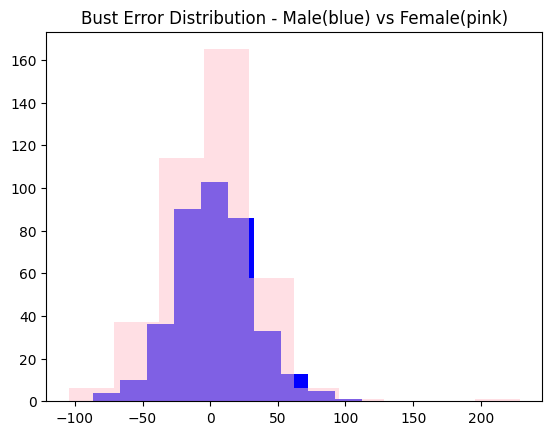

In [133]:
plt.hist(male_error_data["bust_errors"], bins=10, color="blue")
plt.hist(female_error_data["bust_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Bust Error Distribution - Male(blue) vs Female(pink)")
plt.show()


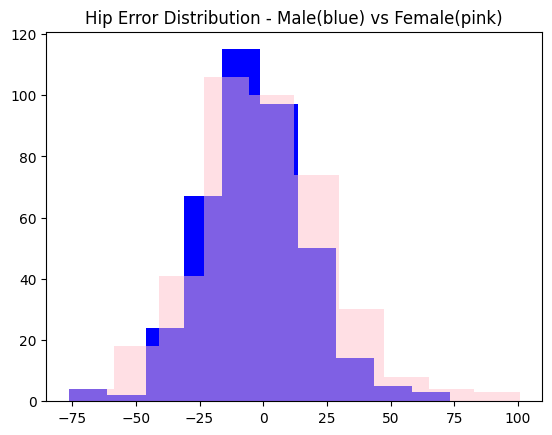

In [134]:
plt.hist(male_error_data["hip_errors"], bins=10, color="blue")
plt.hist(female_error_data["hip_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Hip Error Distribution - Male(blue) vs Female(pink)")
plt.show()

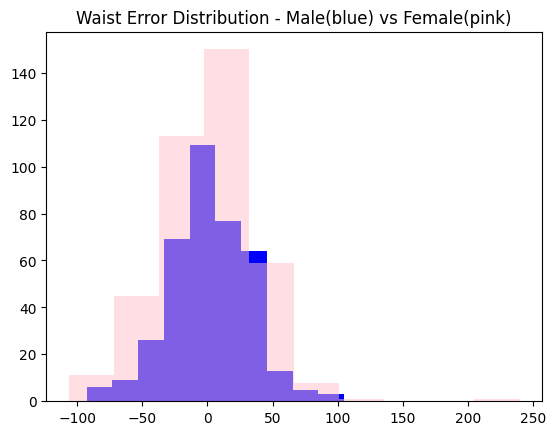

In [135]:
plt.hist(male_error_data["waist_errors"], bins=10, color="blue")
plt.hist(female_error_data["waist_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Waist Error Distribution - Male(blue) vs Female(pink)")
plt.show()

- The graphs indicate a relatively similar distribution of errors but do confirm higher error rates when predicting female data.

### Further Error Analysis

In [136]:
error_analyzer.get_category_counts("age")

age
0    259
1     80
2     86
3     82
4     57
5     40
6     47
7     56
8     36
9     26
dtype: int64

In [137]:
error_analyzer.get_category_bin("age", 0)
# Most of the examples have individuals aged 15 to 20

(14.946, 20.4)

In [138]:
error_analyzer.get_category_means("age")

,gender,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
age,,,,,,,,,,,,
0,0.513514,1662.366795,61.010425,857.243243,735.849421,934.563707,2.377865,-4.496217,-0.183032,23.406429,16.782989,22.573065
1,0.537500,1676.100000,65.787500,891.850000,776.862500,953.250000,3.846179,-1.028765,2.038709,20.389435,18.692686,25.176397
2,0.523256,1677.267442,67.083721,909.267442,795.174419,960.802326,-0.142223,-4.423637,2.298813,24.027257,20.503434,28.172359
3,0.524390,1670.195122,67.046341,917.768293,812.073171,952.475610,0.245594,2.015779,-1.718056,21.220778,13.834271,25.434362
4,0.614035,1664.631579,66.975439,916.105263,812.807018,949.315789,5.757054,-3.974518,8.081900,23.926531,15.231504,24.748122
5,0.400000,1617.050000,61.337500,896.100000,791.125000,923.800000,7.961419,1.539721,11.813277,25.213850,22.955893,34.691039
6,0.425532,1616.170213,66.459574,940.744681,856.914894,950.234043,6.571006,1.165385,-2.200426,25.226265,22.198689,24.956560
7,0.375000,1598.482143,64.594643,949.375000,854.464286,935.803571,-3.841728,5.986485,1.497670,26.422231,21.521575,31.128229
8,0.250000,1566.388889,62.022222,933.944444,854.416667,927.611111,8.936530,5.109044,1.879151,31.371068,19.595625,35.792282


- We can see that the model does generally worse for older people
- This is likely due to the under representation of older groups in the dataset as was previously established.

In [139]:
error_analyzer.get_category_means("height")

,gender,age,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
height,,,,,,,,,,,,
0,0.000000,46.928571,52.392857,884.714286,781.000000,894.428571,5.546256,10.397997,12.924044,17.512568,18.225223,29.202814
1,0.000000,45.564103,54.374359,897.871795,800.897436,905.179487,-5.879252,9.145225,-9.139627,24.818898,27.561728,27.744438
2,0.010638,37.489362,55.229787,876.106383,770.148936,921.712766,1.259713,-1.331005,-2.957565,26.418245,20.349758,30.791853
3,0.084615,33.669231,56.565385,870.069231,753.300000,928.938462,0.514903,-5.379483,1.933309,24.952113,19.801047,26.587209
4,0.330769,31.230769,59.563077,867.438462,756.230769,926.515385,6.858248,-0.222048,2.313245,24.412872,18.017263,26.763757
5,0.740385,31.605769,67.067308,911.250000,800.269231,946.451923,1.054241,-1.738027,5.383380,22.535651,17.644869,22.127565
6,0.941667,30.550000,70.316667,917.108333,810.958333,955.008333,3.018609,-4.774338,3.239918,21.977624,15.851701,22.986393
7,0.975610,27.731707,75.653659,938.268293,834.170732,977.743902,3.396831,-1.554465,1.434131,25.693797,16.347267,25.881259
8,1.000000,26.545455,76.129545,926.136364,823.159091,982.363636,5.613730,-6.572506,-3.094744,19.197063,15.492375,23.721227


In [30]:
error_analyzer.get_category_counts("height")

height
0     14
1     39
2     94
3    130
4    130
5    104
6    120
7     82
8     44
9     12
dtype: int64

In [140]:
error_analyzer.get_category_means("weight")

,gender,age,height,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
weight,,,,,,,,,,,,
0,0.066667,28.693333,1566.146667,780.666667,661.080000,860.880000,0.897995,-3.777331,-0.229547,22.467655,17.541306,22.540433
1,0.191489,31.638298,1595.622340,843.643617,721.611702,903.765957,0.224238,-1.629143,2.942762,23.519539,18.289873,23.125502
2,0.399038,33.557692,1630.548077,889.658654,780.144231,937.884615,2.398813,-3.707318,-1.867745,21.698390,18.497395,26.862112
3,0.822695,33.631206,1703.921986,929.808511,819.659574,955.879433,-1.271650,-0.198718,2.398891,24.820911,16.662578,26.790681
4,0.872340,35.819149,1717.457447,967.776596,875.542553,993.776596,11.796997,-0.984421,8.327568,25.802229,20.492156,26.797924
5,0.921053,33.500000,1749.657895,1018.421053,938.000000,1036.500000,5.715025,-2.623490,-1.559169,26.731776,19.242527,29.969040
6,0.933333,25.733333,1743.933333,1065.133333,1005.733333,1063.533333,5.887819,16.449416,-12.283489,35.898161,26.177499,39.904614
7,1.000000,31.428571,1784.714286,1092.571429,1040.714286,1114.000000,15.191416,-9.974214,1.986238,25.377579,14.107254,32.608030
8,1.000000,22.000000,1806.500000,1128.000000,1061.000000,1159.000000,17.651088,-8.996999,26.981466,17.651088,19.583584,26.981466


In [141]:
error_analyzer.get_category_counts("weight")

weight
0     75
1    188
2    208
3    141
4     94
5     38
6     15
7      7
8      2
9      1
dtype: int64

### Unseen Targets Test Set Predictions

In [143]:
# predict_serving_data(models, "data/test.csv", save_path="data/baseline_predicted.csv")